# Images used in thesis

## Imports

In [110]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imwrite, imread

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models

import sys
sys.path.append('code')
from eval_functions import calculate_score
from Loss_Metrics import jaccard_coef, jaccard_coef_loss, dice_coef_loss
sys.path.append('../')

from eval_functions import calculate_score

## Display MapAI images

In [67]:
def display_dataset(path, data_name):
    
    # Find and display aerial image
    plt.figure(figsize=(5,5))
    aerial_img = cv.imread(os.path.normpath(path + '/image/' + data_name + '.PNG'))
    aerial_img = cv.cvtColor(aerial_img, cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    plt.axis('off')
    plt.show()
    
    # Find and display lidar image
    plt.figure(figsize=(5,5))
    lidar_img = np.load(os.path.normpath(path + '/lidar/' + data_name + '.npy'))
    plt.imshow(lidar_img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Find and display ground truth image
    plt.figure(figsize=(5,5))
    mask_img = cv.imread(os.path.normpath(path + '/mask/' + data_name + '.PNG'))
    plt.imshow(mask_img, cmap='gray')
    plt.axis('off')
    plt.show()

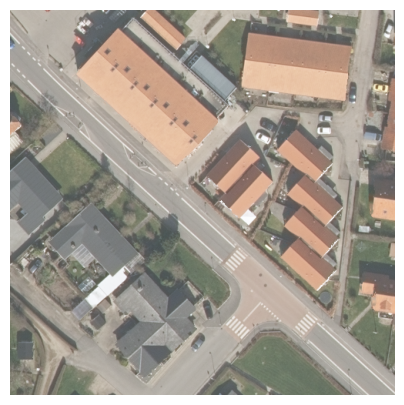

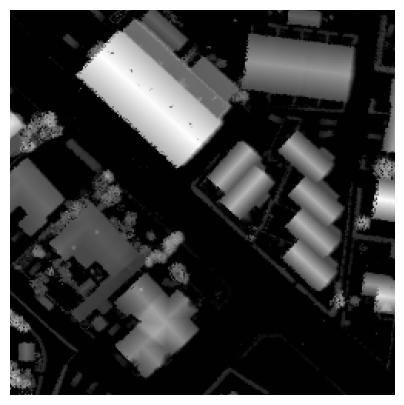

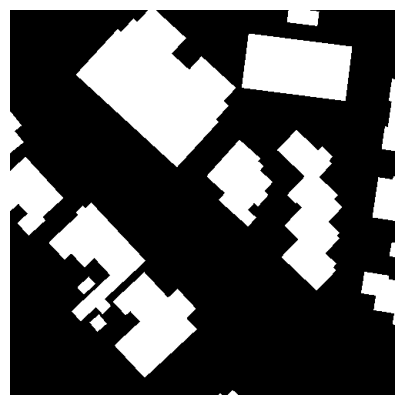

In [68]:
display_dataset(os.path.normpath('dataset/MapAI/train'), '6112_694_65')

## Display Preprocessed MapAI images

In [164]:
def display_dataset(path, data_name):
    
    # Find and display aerial image
    plt.figure(figsize=(5,5))
    aerial_img = cv.imread(os.path.normpath(path + '/image/train/' + data_name + '.PNG'))
    aerial_img = cv.cvtColor(aerial_img, cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    plt.axis('off')
    plt.show()
    
    # Find and display lidar image
    plt.figure(figsize=(5,5))
    lidar_img = imread(os.path.normpath(path + '/rgbLiDAR/train/' + data_name + '.tif'))
    plt.imshow(lidar_img[:, :, 3], cmap='gray')
    plt.axis('off')
    plt.show()
    
    # Find and display ground truth image
    plt.figure(figsize=(5,5))
    mask_img = cv.imread(os.path.normpath(path + '/mask/train/' + data_name + '.PNG'))
    mask_img[mask_img>0.5]=255
    plt.imshow(mask_img, cmap='gray')
    plt.axis('off')
    plt.show()

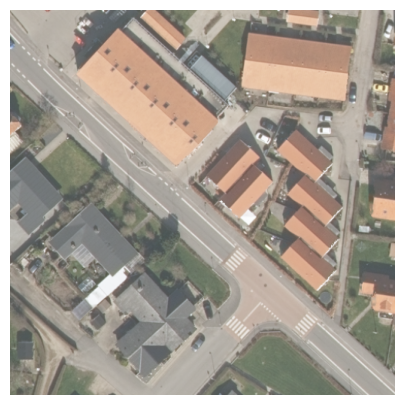

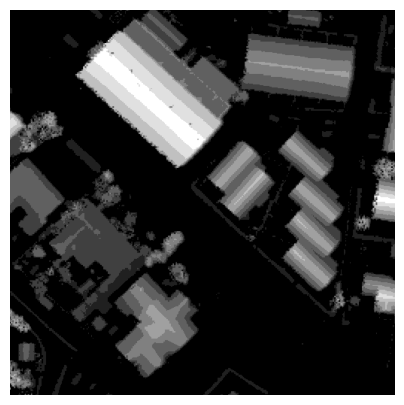

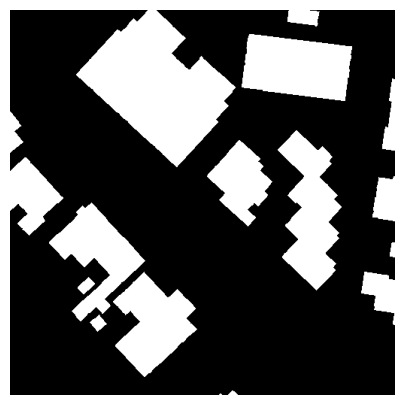

In [165]:
display_dataset(os.path.normpath('dataset/MapAI/preprocessed_train/'), '6112_694_65')

## Data Augmentation

In [87]:
train_set = 'rgbLiDAR'
color_mode = 'rgba'
mask = 'mask'
target_size=(512, 512)
seed = 420
batch_size = 6

# Setting augmentation args
img_data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.3,
                         height_shift_range=0.3,
                         shear_range=0.5,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')
mask_data_gen_args = dict(rotation_range=90,
                          width_shift_range=0.3,
                          height_shift_range=0.3,
                          shear_range=0.5,
                          zoom_range=0.3,
                          horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='reflect',
                          preprocessing_function=lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) # Binarize the output.

# Creating data generator for train and validation images and masks
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_train/' + train_set),
                                                           target_size=target_size,
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           color_mode=color_mode,
                                                           class_mode=None)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_train/' + mask),
                                                         target_size=target_size,
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode='grayscale',
                                                         class_mode=None)

train_generator = zip(image_generator, mask_generator)

Found 7000 images belonging to 1 classes.
Found 7000 images belonging to 1 classes.


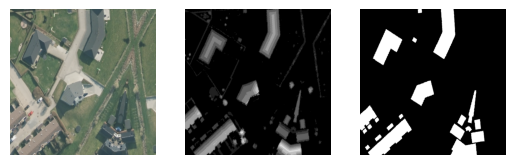

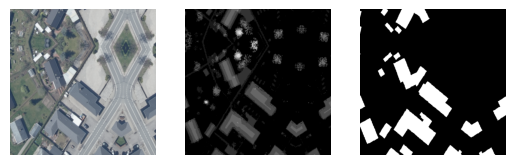

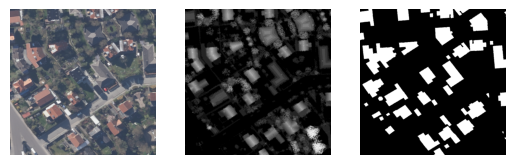

In [105]:
x, y = train_generator.__next__()

for i in range(0,3):
    image = x[i]
    aerial_img = cv.cvtColor(image[:, :, 0:3], cv.COLOR_BGR2RGB)
    mask = y[i]
    plt.subplot(1,3,1)
    plt.imshow(np.array(aerial_img[:, :, 0:3]).astype(np.uint))
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(image[:, :, 3],cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(mask*255, cmap='gray')
    plt.axis('off')
    plt.show()

## Predict Test Images

In [109]:
model_name = 'LiDAR_UNet_Baseline_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(x)

C:\Users\erikf\anaconda3\envs\master\lib\site-packages\keras\layers\core\lambda_layer.py:324: UserWarning: UNet is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


1/1 [==============================] - 19s 19s/step


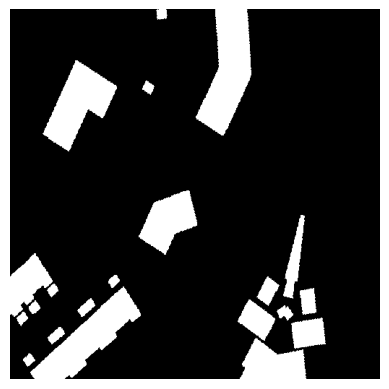

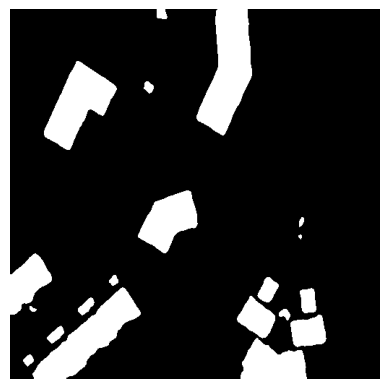

______________________________________________________


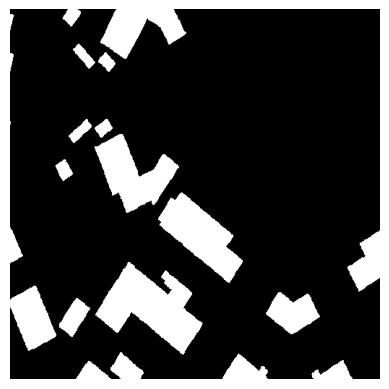

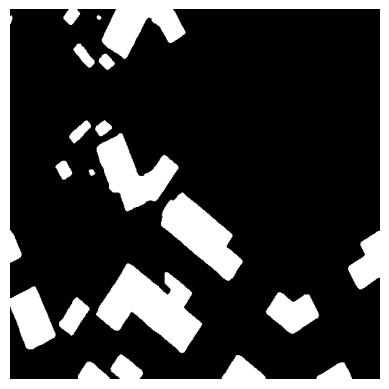

______________________________________________________


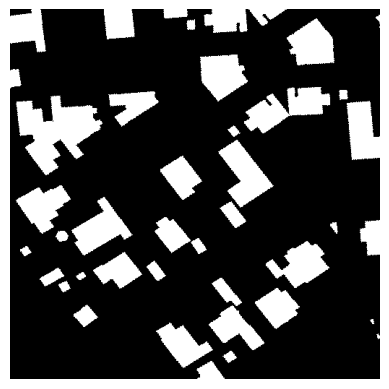

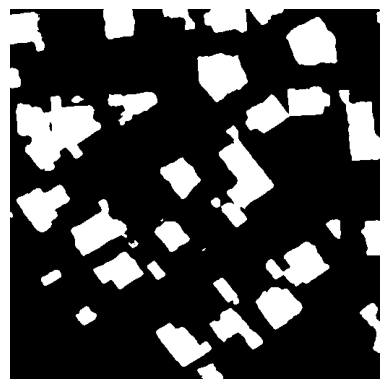

______________________________________________________


In [116]:
for i in range(0,3):
    mask = y[i]
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow((Y_pred[i]>0.5),cmap='gray')
    plt.axis('off')
    plt.show()
    print('______________________________________________________')

## Predict Validation Images

In [119]:
train_set = 'rgbLiDAR'
color_mode = 'rgba'
mask = 'mask'
target_size=(512, 512)
seed = 420
batch_size = 6

val_data_generator = ImageDataGenerator()
valid_img_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_validation/' + train_set),
                                                             target_size=target_size,
                                                             seed=seed,
                                                             batch_size=batch_size,
                                                             color_mode=color_mode,
                                                             class_mode=None)

valid_mask_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/preprocessed_validation/' + mask),
                                                              target_size=target_size,
                                                              seed=seed,
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              class_mode=None)

val_generator = zip(image_generator, mask_generator)
x, y = val_generator.__next__()

model_name = 'LiDAR_UNet_Baseline_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(x)

Found 1500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
1/1 [==============================] - 20s 20s/step


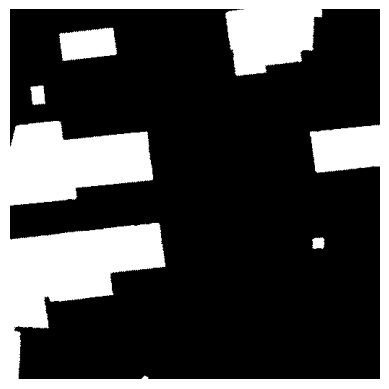

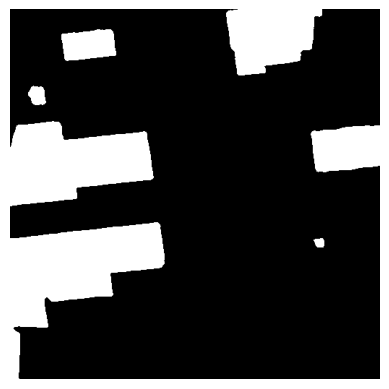

______________________________________________________


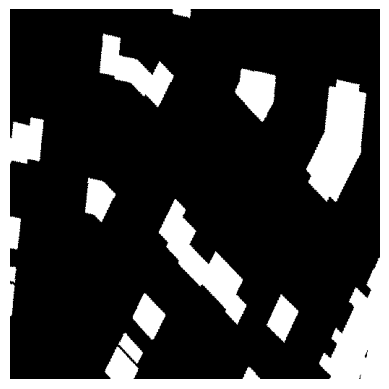

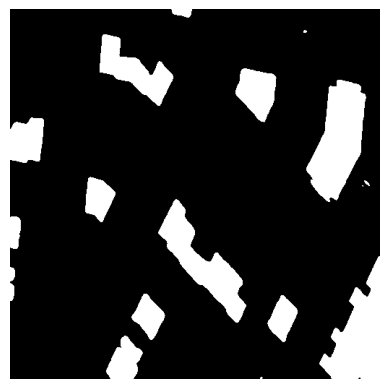

______________________________________________________


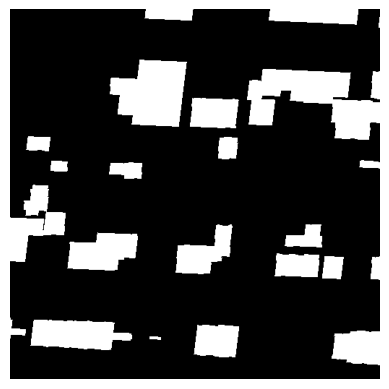

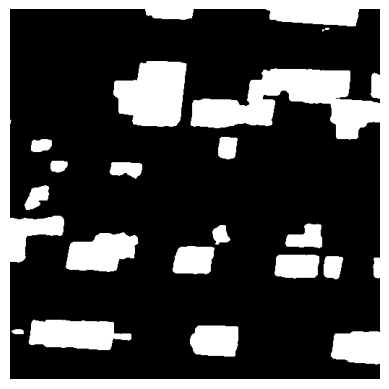

______________________________________________________


In [120]:
for i in range(0,3):
    mask = y[i]
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.show()
    plt.imshow((Y_pred[i]>0.5),cmap='gray')
    plt.axis('off')
    plt.show()
    print('______________________________________________________')

## Predict Test Images

In [132]:
# Finding the number of images in each dataset
test_path = os.path.normpath('dataset/MapAI/preprocessed_task2_test/rgbLiDAR')
no_test_images = 11

# Defining size of images
IMG_HEIGHT = 512
IMG_WIDTH = 512

# Creating NumPy arrays for the different subsets
X_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH, 4), dtype=np.uint8)
Y_test = np.zeros((no_test_images, IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

# Adding images to NumPy arrays
img_path = os.path.normpath('dataset/MapAI/preprocessed_task2_test/rgbLiDAR')
mask_path = os.path.normpath('dataset/MapAI/preprocessed_task2_test/mask')

with os.scandir(img_path) as entries:
    for n, entry in enumerate(entries):
        filename = entry.name.split('.')
        img = imread(os.path.normpath(img_path + '/' + filename[0] + '.tif'))
        X_test[n] = img
        mask = cv.imread(os.path.normpath(mask_path + '/' + filename[0] + '.png'))
        mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
        Y_test[n] = mask
        if n == 10:
            break
        
print('X_train size: ' + str(len(X_test)))
print('Y_train size: ' + str(len(Y_test)))



X_train size: 11
Y_train size: 11


In [133]:
# Load model
model_name = 'LiDAR_UNet_Baseline_Checkpoint.h5'
model = models.load_model(os.path.normpath('models/' + model_name), custom_objects={'dice_coef_loss': dice_coef_loss, 'jaccard_coef': jaccard_coef})
Y_pred = model.predict(X_test)

1/1 [==============================] - 36s 36s/step


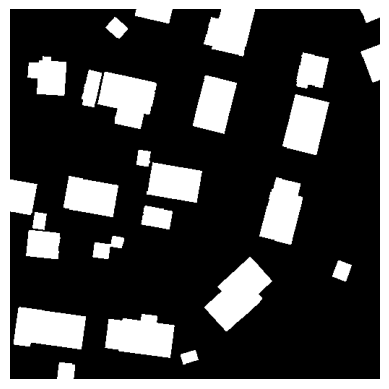

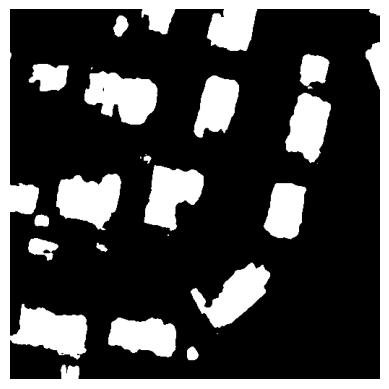

In [139]:
index = 6

plt.imshow(Y_test[index], cmap='gray')
plt.axis('off')
plt.show()
plt.imshow((Y_pred > 0.5)[index], cmap='gray')
plt.axis('off')
plt.show()

## Test Time Augmentation

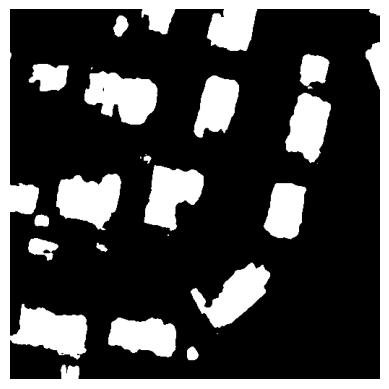

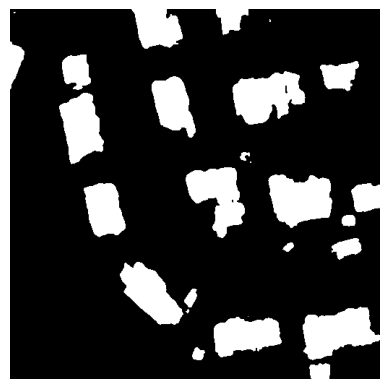

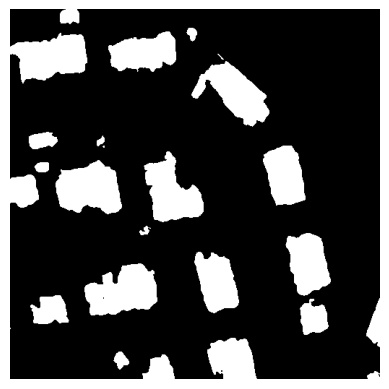

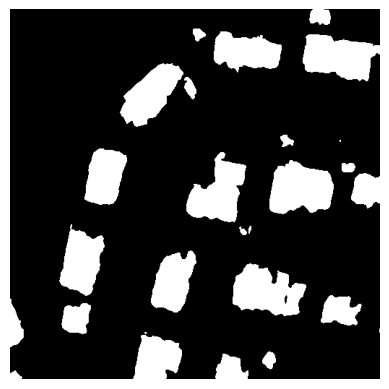

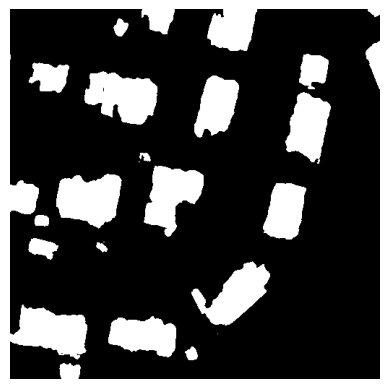

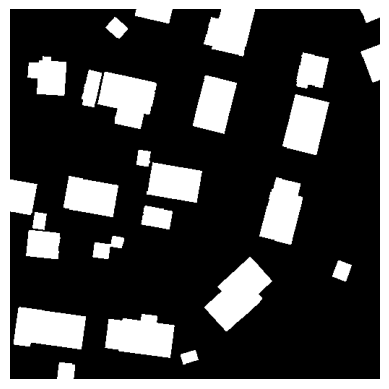

In [144]:
prediction_original = model.predict(np.expand_dims(X_test[6], axis=0), verbose=0)[0]
plt.imshow(prediction_original > 0.5, cmap='gray')
plt.axis('off')
plt.show()

prediction_lr = model.predict(np.expand_dims(np.fliplr(X_test[6]), axis=0), verbose=0)[0]
plt.imshow(prediction_lr > 0.5, cmap='gray')
plt.axis('off')
plt.show()
prediction_lr = np.fliplr(prediction_lr)

prediction_ud = model.predict(np.expand_dims(np.flipud(X_test[6]), axis=0), verbose=0)[0]
plt.imshow(prediction_ud > 0.5, cmap='gray')
plt.axis('off')
plt.show()
prediction_ud = np.flipud(prediction_ud)

prediction_lr_ud = model.predict(np.expand_dims(np.fliplr(np.flipud(X_test[6])), axis=0), verbose=0)[0]
plt.imshow(prediction_lr_ud > 0.5, cmap='gray')
plt.axis('off')
plt.show()
prediction_lr_ud = np.fliplr(np.flipud(prediction_lr_ud))

predicition = (prediction_original + prediction_lr + prediction_ud + prediction_lr_ud) / 4
plt.imshow(predicition > 0.3, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(Y_test[6], cmap='gray')
plt.axis('off')
plt.show()

## Display original and preprocessed LiDAR data

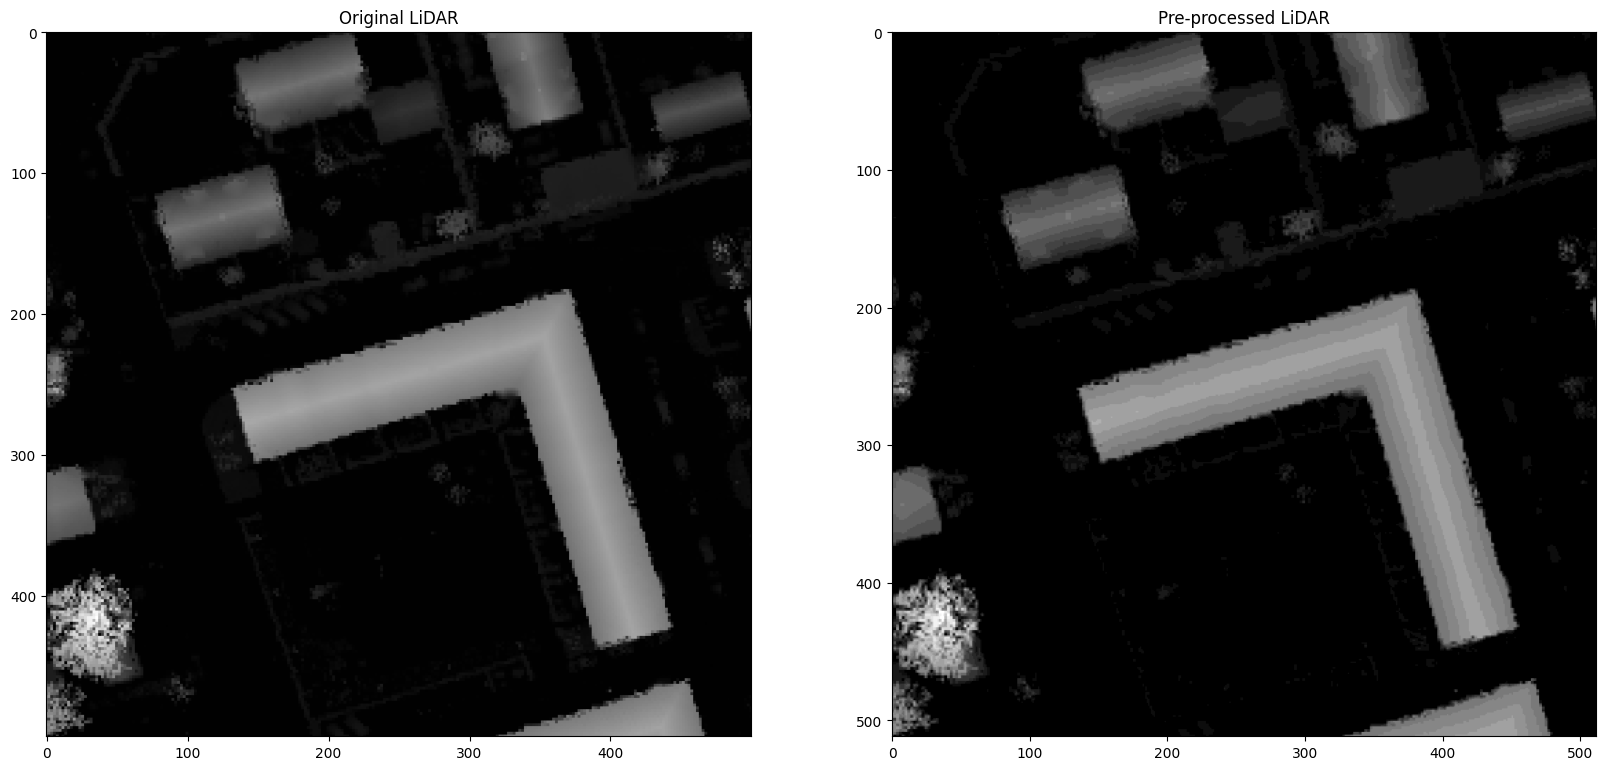

In [4]:
data_name = '6259_563_80'
path_new = os.path.normpath('dataset/MapAI/preprocessed_train')
path_original = os.path.normpath('dataset/MapAI/train')

plt.figure(figsize=(20,20))

lidar_data = np.load(os.path.normpath(path_original + '/lidar/' + data_name + '.npy'))
rgb_lidar = imread(os.path.normpath(path_new + '/rgbLiDAR/train/' + data_name + '.tif'))

plt.subplot(121)
plt.title('Original LiDAR')
plt.imshow(lidar_data, cmap='gray')

plt.subplot(122)
plt.title('Pre-processed LiDAR')
plt.imshow(rgb_lidar[:, :, 3], cmap='gray')
plt.show()


## Preliminary Tests U-Net

In [41]:
def export_logs(files_names):
    prefix = 'logs'
    val_jaccard = {}
    val_loss = {}
    epoch = {}
    for file_name in files_names:
        val_jaccard[file_name] = []
        val_loss[file_name] = []
        epoch[file_name] = []
    
    for file_name in val_jaccard.keys():
        with open(os.path.normpath(prefix + '/' + file_name)) as topo_file:
            for line in topo_file:
                csv = line.replace('\n', '').split(',')
                if csv[0] == 'epoch':
                    continue
                val_jaccard[file_name].append(float(csv[6]))
                val_loss[file_name].append(float(csv[7]))
                epoch[file_name].append(int(csv[0])+1)
    return val_jaccard, val_loss, epoch
    

### Batch Normalization Order

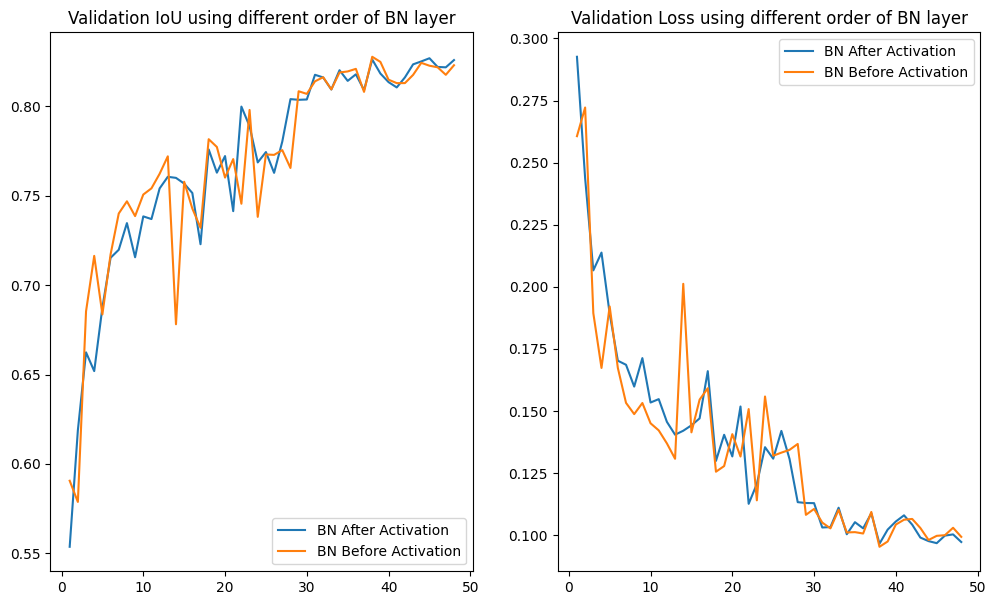

In [44]:
file_names = ['1_UNet_BN_After_log', '1_UNet_BN_Before_log']
val_jaccard, val_loss, epoch = export_logs(file_names)
            
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='BN After Activation')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='BN Before Activation')
plt.legend(loc='lower right')
plt.title('Validation IoU using different order of BN layer')

plt.subplot(1, 2, 2)
plt.plot(epoch[file_names[0]], val_loss[file_names[0]], label='BN After Activation')
plt.plot(epoch[file_names[1]], val_loss[file_names[1]], label='BN Before Activation')
plt.legend(loc='upper right')
plt.title('Validation Loss using different order of BN layer')
plt.show()

### Initial LR

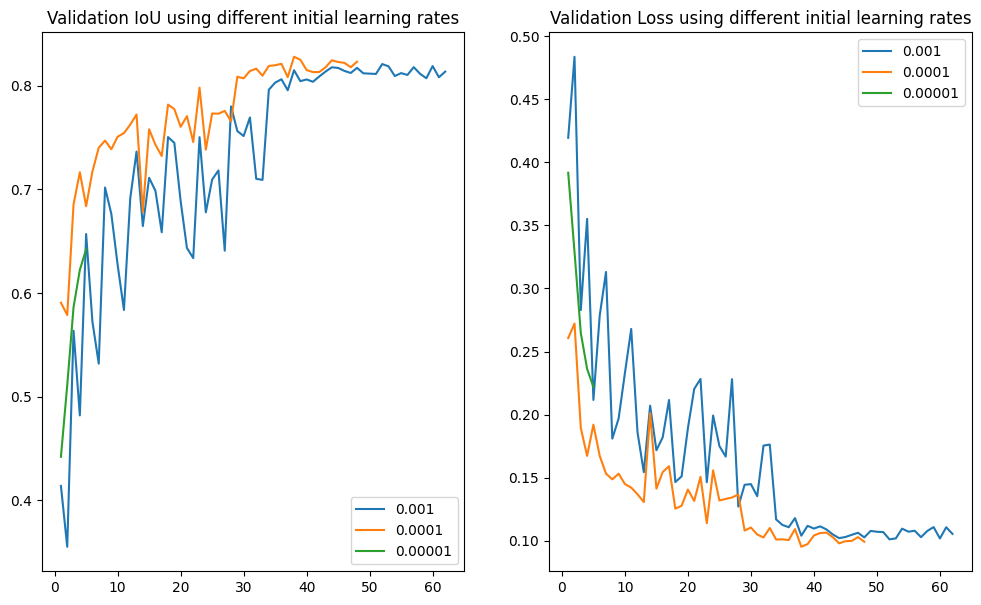

In [145]:
file_names = ['1_UNet_001_log', '1_UNet_BN_Before_log', '1_UNet_00001_log']
val_jaccard, val_loss, epoch = export_logs(file_names)
            
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(epoch[file_names[0]], val_jaccard[file_names[0]], label='0.001')
plt.plot(epoch[file_names[1]], val_jaccard[file_names[1]], label='0.0001')
plt.plot(epoch[file_names[2]], val_jaccard[file_names[2]], label='0.00001')
plt.legend(loc='lower right')
plt.title('Validation IoU using different initial learning rates')

plt.subplot(1, 2, 2)
plt.plot(epoch[file_names[0]], val_loss[file_names[0]], label='0.001')
plt.plot(epoch[file_names[1]], val_loss[file_names[1]], label='0.0001')
plt.plot(epoch[file_names[2]], val_loss[file_names[2]], label='0.00001')
plt.legend(loc='upper right')
plt.title('Validation Loss using different initial learning rates')
plt.show()

### Loss Function

### Batch Size

## Preliminary Tests CT-UNet

### Batch Normalization Order

### Initial LR

### Loss Function

### Batch Size